In [2]:
import math
import time
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Scripts.airfoil as af
import Scripts.fishUtilities as fu
import Scripts.fishFits as ff
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve

from pathlib import Path

from sklearn.metrics import r2_score
from lmfit import Parameters, minimize, fit_report
from scipy.optimize import curve_fit
from lmfit.models import PowerLawModel

# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})

In [3]:
def power_law(xData, a, b):
        return a * xData ** b

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [4]:
def power_fit_lmfit(params, x, y):
        a = params['a']
        b = params['b']
        y_fit = a*x**b
        
        return y_fit-y

def func_powerlaw(x, a, b):
        return a*x**b

def calc_rsquared(x, y, amplitude, exponent):
    yhat = func_powerlaw(x, amplitude, exponent)

    return r2_score(y, yhat)

In [5]:
imagePath = r'./Pictures'
databasePath = r'./'
figurePath = r'./'
    
specimen = r'cyberfish'

In [6]:
imagePathSide = fu.get_image_files(imagePath, specimen + 'SideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, specimen + 'Side.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, specimen + 'TopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, specimen + 'Top.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

In [7]:
# Split work depending on input images
def process_top(imageList):
    # make a copy of the image
    topImage = imageList[0].copy()
    if(len(imageList) < 2):
        topImageFull = imageList[0].copy()
    else:
        topImageFull = imageList[1].copy()
    # get contours
    cntsTop, hullTop = fu.get_contours(topImage)
    cntsTopFull, hullTopFull = fu.get_contours(topImageFull)
    
    # Find the area ratio of fins and no fins
    areaTopFull = cv2.contourArea(cntsTopFull)
    areaTopNF = cv2.contourArea(cntsTop)
    areaRatioTop = (1-np.abs(areaTopNF/areaTopFull))

    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(topImage.shape, cntsTop)
    (cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(topImageFull.shape, cntsTopFull)

    # scale contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    areaTopFull, tHullTopFull, bHullTopFull = fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    
    # get min and max points
    maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
    
    # fit data
    topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
    nacaArea, m, thickness, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, np.mean([minPointsTop[0],maxPointsTop[0]]), np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
    
    return ([areaRatioTop, areaTop, nacaArea], [cntsTop, cntsTopFull], [maxPointsTop, minPointsTop],
            [topFitTop, bottomFitTop], [m, thickness, d0], [tHullTop, bHullTop])

In [8]:
def process_side(imageList):
    # make a copy of the image
    sideImage = imageList[0].copy()
    sideImageFull = imageList[1].copy()

    # get contours
    cntsSide, hullSide = fu.get_contours(sideImage)
    cntsSideFull, hullSideFull = fu.get_contours(sideImageFull)
    
    # Find the area ratio of fins and no fins
    areaSideFull = cv2.contourArea(cntsSideFull)
    areaSideNF = cv2.contourArea(cntsSide)
    areaRatioSide = (1-np.abs(areaSideNF/areaSideFull))
    
    (cxSide, cySide), areaSideNF, topHullSide, bottomHullSide = fu.split_by_centroid_side(sideImage.shape, cntsSide)
    (cxSideFull, cySideFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(sideImageFull.shape, cntsSideFull)

    # scale contour data
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    
    # get min and max points
    maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
    
    #fit data
    topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
    
    return (areaRatioSide, [cntsSide, cntsSideFull], [maxPointsSide, minPointsSide], [topFitSide, bottomFitSide], [tHullSide, bHullSide])

In [9]:
# Dictionaries for data
generalData = {'Species Name':[], 'Width Location':[], 'Max Width':[],
               'Height Location':[], 'Max Height':[], 'Side Area':[], 'Top Area':[] }
sideFitData = {'Species Name':[], 'Ta6':[], 'Ta5':[], 'Ta4':[], 'Ta3':[], 'Ta2':[], 'Ta1':[], 'Ta0':[],
              'Ba6':[], 'Ba5':[], 'Ba4':[], 'Ba3':[], 'Ba2':[], 'Ba1':[], 'Ba0':[]}
topFitData = {'Species Name':[], 'Ta4':[], 'Ta3':[], 'Ta2':[], 'Ta1':[], 'Ta0':[],
              'Ba4':[], 'Ba3':[], 'Ba2':[], 'Ba1':[], 'Ba0':[]}

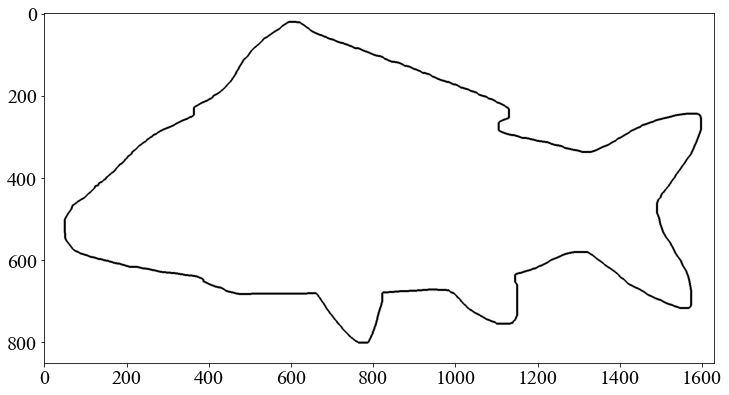

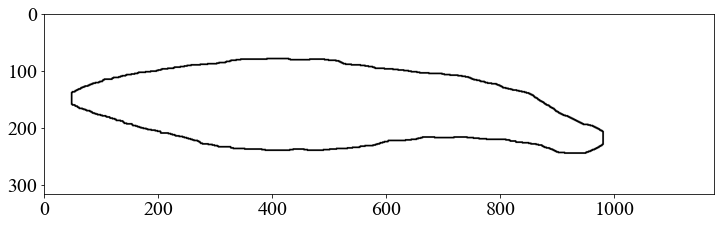

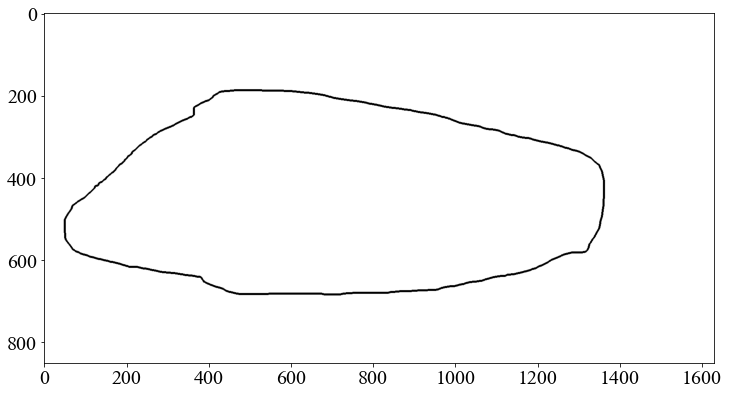

In [10]:
sideArea, sideContours, sidePoints, sideFits, sideHull = process_side([imageSide, imageSideFull])
cntsSideFull = sideContours[1]
cntsSide = sideContours[0]

topArea, topContours, topPoints, topPolyFits, nacaFits, topHull = process_top([imageTop])
cntsTopFull = topContours[1]
cntsTop = topContours[0]

# append general data to dictionary
generalData['Species Name'].append(specimen)
generalData['Width Location'].append(np.mean([topPoints[0][0], topPoints[1][0]]))
generalData['Max Width'].append(topPoints[0][1] + np.abs(topPoints[1][1]))
generalData['Height Location'].append(np.mean([sidePoints[0][0], sidePoints[1][0]]))
generalData['Max Height'].append(sidePoints[0][1] + np.abs(sidePoints[1][1]))
generalData['Side Area'].append(sideArea)
generalData['Top Area'].append(topArea[0])
    
# append side data to dictionary
sideFitData['Species Name'].append(specimen)
sideFitData['Ta6'].append(sideFits[0][0])
sideFitData['Ta5'].append(sideFits[0][1])
sideFitData['Ta4'].append(sideFits[0][2])
sideFitData['Ta3'].append(sideFits[0][3])
sideFitData['Ta2'].append(sideFits[0][4])
sideFitData['Ta1'].append(sideFits[0][5])
sideFitData['Ta0'].append(sideFits[0][6])
sideFitData['Ba6'].append(sideFits[1][0])
sideFitData['Ba5'].append(sideFits[1][1])
sideFitData['Ba4'].append(sideFits[1][2])
sideFitData['Ba3'].append(sideFits[1][3])
sideFitData['Ba2'].append(sideFits[1][4])
sideFitData['Ba1'].append(sideFits[1][5])
sideFitData['Ba0'].append(sideFits[1][6])
    
# append top data to dictionary
topFitData['Species Name'].append(specimen)
topFitData['Ta4'].append(nacaFits[0])
topFitData['Ta3'].append(nacaFits[1])
topFitData['Ta2'].append(nacaFits[2])
topFitData['Ta1'].append(0)
topFitData['Ta0'].append(0)
topFitData['Ba4'].append(nacaFits[0])
topFitData['Ba3'].append(nacaFits[1])
topFitData['Ba2'].append(nacaFits[2])
topFitData['Ba1'].append(0)
topFitData['Ba0'].append(0)

sideMask = np.zeros(imageSide.shape, dtype=np.uint8)
cv2.drawContours(sideMask, [cntsSideFull], -1, (255, 255, 255), 3)
sideMask = cv2.bitwise_not(sideMask)

sideMaskNF = np.zeros(imageSide.shape, dtype=np.uint8)
cv2.drawContours(sideMaskNF, [cntsSide], -1, (255, 255, 255), 3)
sideMaskNF = cv2.bitwise_not(sideMaskNF)

topMask = np.zeros(imageTop.shape, dtype=np.uint8)
cv2.drawContours(topMask, [cntsTopFull], -1, (255, 255, 255), 2)
topMask = cv2.bitwise_not(topMask)

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plt.subplots(figsize=(12, 10))
ax1.imshow(sideMask)
#fig1.savefig(Path(figurePath).joinpath('sideContours.png'), facecolor='w', bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(12, 10))
ax2.imshow(topMask)
#fig2.savefig(Path(figurePath).joinpath('topContour.png'), facecolor='w', bbox_inches='tight')

fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.imshow(sideMaskNF)
#fig3.savefig(Path(figurePath).joinpath('sideContoursNF.png'), facecolor='w', bbox_inches='tight')

In [11]:
# All data into pandas dataframes
fish_general = pd.DataFrame(data=generalData)
fish_side = pd.DataFrame(data=sideFitData)    
fish_top = pd.DataFrame(data=topFitData)

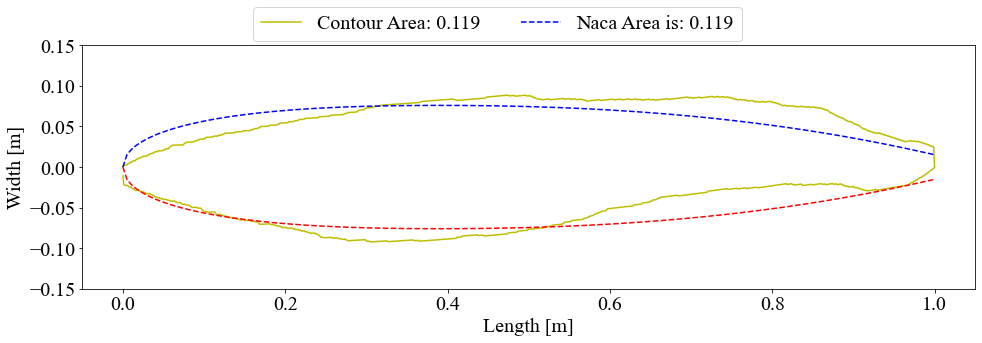

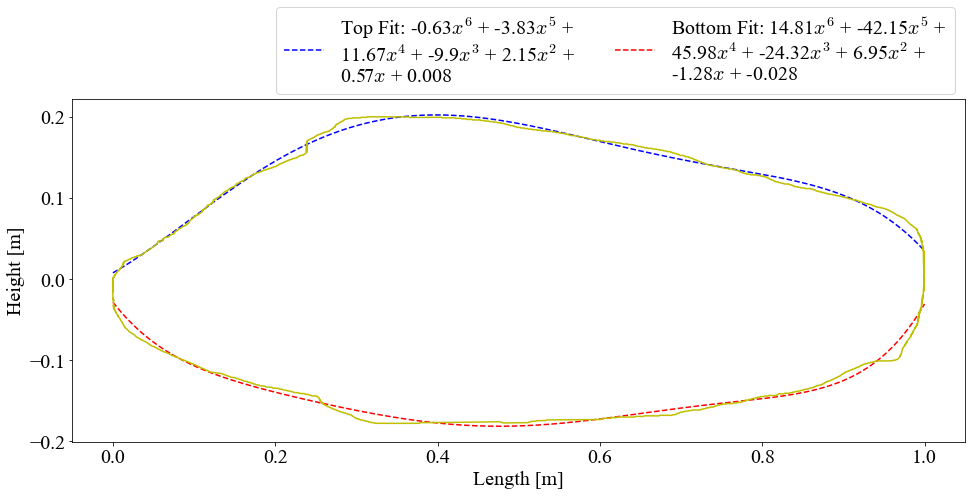

In [12]:
dx = np.linspace(0, 1.0, 200)
#nacaFits = [0.3973, 0.16, 0.01]
m = nacaFits[0]
thickness = nacaFits[1]
d0 = nacaFits[2]

topPolySide = np.poly1d(sideFits[0])
bottomPolySide = np.poly1d(sideFits[1])
topPolyTop = np.poly1d(topPolyFits[0])
bottomPolyTop = np.poly1d(topPolyFits[1])

X, Y = af.naca4_modified(dx, m, thickness, 1.0, d0)
fig4, ax4 = plt.subplots(figsize=(16, 15))
ax4.plot(topHull[0][0], topHull[0][1], 'y', label="Contour Area: " + str(np.round(topArea[1], 3)))
ax4.plot(topHull[1][0], topHull[1][1], 'y')
ax4.plot(X[0], Y[0], 'b--', label="Naca Area is: " + str(np.round(topArea[2], 3))) 
ax4.plot(X[1], Y[1], 'r--')
ax4.set_xlabel("Length [m]")
ax4.set_ylabel("Width [m]")
ax4.set_ylim([-.15, 0.15])
ax4.set_aspect('equal')
ax4.legend(loc='best', ncol=2, bbox_to_anchor=(0.75, 1.2))
#fig4.savefig(Path(figurePath).joinpath('NacaFit.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

sideFitData['Ta6'].append(sideFits[0][0])
sideFitData['Ta5'].append(sideFits[0][1])
sideFitData['Ta4'].append(sideFits[0][2])
sideFitData['Ta3'].append(sideFits[0][3])
sideFitData['Ta2'].append(sideFits[0][4])
sideFitData['Ta1'].append(sideFits[0][5])
sideFitData['Ta0'].append(sideFits[0][6])
sideFitData['Ba6'].append(sideFits[1][0])
sideFitData['Ba5'].append(sideFits[1][1])
sideFitData['Ba4'].append(sideFits[1][2])
sideFitData['Ba3'].append(sideFits[1][3])
sideFitData['Ba2'].append(sideFits[1][4])
sideFitData['Ba1'].append(sideFits[1][5])
sideFitData['Ba0'].append(sideFits[1][6])


fig5, ax5 = plt.subplots(figsize=(16, 15))
ax5.plot(dx, topPolySide(dx), 'b--', label='Top Fit: ' + str(np.round(sideFits[0][0],2)) + '$x^6$ + ' + str(np.round(sideFits[0][1],2)) + '$x^5$ + \n' + str(np.round(sideFits[0][2],2)) + '$x^4$ + ' + str(np.round(sideFits[0][3],2)) + '$x^3$ + ' + str(np.round(sideFits[0][4],2)) + '$x^2$ + \n' + str(np.round(sideFits[0][5],2)) + '$x$ + ' + str(np.round(sideFits[0][6],3)))
ax5.plot(dx, bottomPolySide(dx), 'r--', label='Bottom Fit: ' + str(np.round(sideFits[1][0],2)) + '$x^6$ + ' + str(np.round(sideFits[1][1],2)) + '$x^5$ + \n' + str(np.round(sideFits[1][2],2)) + '$x^4$ + ' + str(np.round(sideFits[1][3],2)) + '$x^3$ + ' + str(np.round(sideFits[1][4],2)) + '$x^2$ + \n' + str(np.round(sideFits[1][5],2)) + '$x$ + ' + str(np.round(sideFits[1][6],3)))

ax5.plot(sideHull[0][0], sideHull[0][1], 'y')
ax5.plot(sideHull[1][0], sideHull[1][1], 'y')
ax5.set_xlabel("Length [m]")
ax5.set_ylabel("Height [m]")
ax5.set_aspect('equal')
ax5.legend(loc=1, ncol=2, bbox_to_anchor=(1.0, 1.3))
#fig5.savefig(Path(figurePath).joinpath('sideFit.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [13]:
from scipy.special import ellipe

def square_ellipse(length, height, width):
    a = length/2
    b = height/2
    e_sq = 1.0 - b**2/a**2
    C = 4 * a *ellipe(e_sq)
    area = np.pi * a * b

    return C * width, area * width

scaledLength = np.linspace(0.1, 100, 100)

density = 1026.021

cyberfish_area = np.zeros(len(scaledLength))
cyberfish_volume = np.zeros(len(scaledLength))
madeline_area = np.zeros(len(scaledLength))
madeline_volume = np.zeros(len(scaledLength))
hugin_area = np.zeros(len(scaledLength))
hugin_volume = np.zeros(len(scaledLength))
D_calc = np.zeros(len(scaledLength))
Sr_calc = np.zeros(len(scaledLength))

for idx, length in enumerate(scaledLength):
    cyberfish_area[idx], D_calc[idx] = sea.determine_surface_area(1, 2, 0, length*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
    cyberfish_volume[idx], height, width = ve.determine_volume(1, 2, 0, length*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
    Sr_calc[idx] = length/D_calc[idx]

    # note that width and height dimensions are scaled with length
    madeline_area[idx], madeline_volume[idx] = square_ellipse(length, length*0.167, length*0.564)
    hugin_area[idx] = sea.ellipsoidApproximation(length, length*0.167, length*0.167)
    hugin_volume[idx] = ve.ellipsoidApproximation(length, length*0.167, length*0.167)

In [14]:
from scipy.interpolate import interp1d

# deterimine the lengths in which the volumes are the same
dorado_volume = ve.ellipsoidApproximation(5.24, 0.533, 0.533)

# interpolate the numbers to get a better estimation of the length
f = interp1d(scaledLength, cyberfish_volume, kind='cubic')
xnew = np.linspace(0.1, 100, num=10000, endpoint=True)
length_cyberfish = xnew[np.where(f(xnew) >= dorado_volume)[0][0]]

f = interp1d(scaledLength, madeline_volume, kind='cubic')
length_madeline = xnew[np.where(f(xnew) >= dorado_volume)[0][0]]

f = interp1d(scaledLength, hugin_volume, kind='cubic')
length_hugin = xnew[np.where(f(xnew) >= dorado_volume)[0][0]]

In [15]:
cyberfish_volume, height, width = ve.determine_volume(1, 2, 0, length_cyberfish*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)

# note that width and height dimensions are scaled with length
_, madeline_volume = square_ellipse(length_madeline, length_madeline*0.167, length_madeline*0.564)
hugin_volume = ve.ellipsoidApproximation(length_hugin, length_hugin*0.167, length_hugin*0.167)

print('Dorado Volume: ' + str(dorado_volume) + '\n',
      '(' + str(length_cyberfish) + ',' + str(cyberfish_volume) + ') \n', 
      '(' + str(length_madeline) + ',' + str(madeline_volume) + ') \n', 
      '(' + str(length_hugin) + ',' + str(hugin_volume) + ')')

Dorado Volume: 0.7794429394193525
 (3.3570657065706575,0.7823744028460509) 
 (2.1981098109810984,0.7856581328761497) 
 (3.7666966696669673,0.7803932581332911)


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f81f871b970>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f81f8754070>)

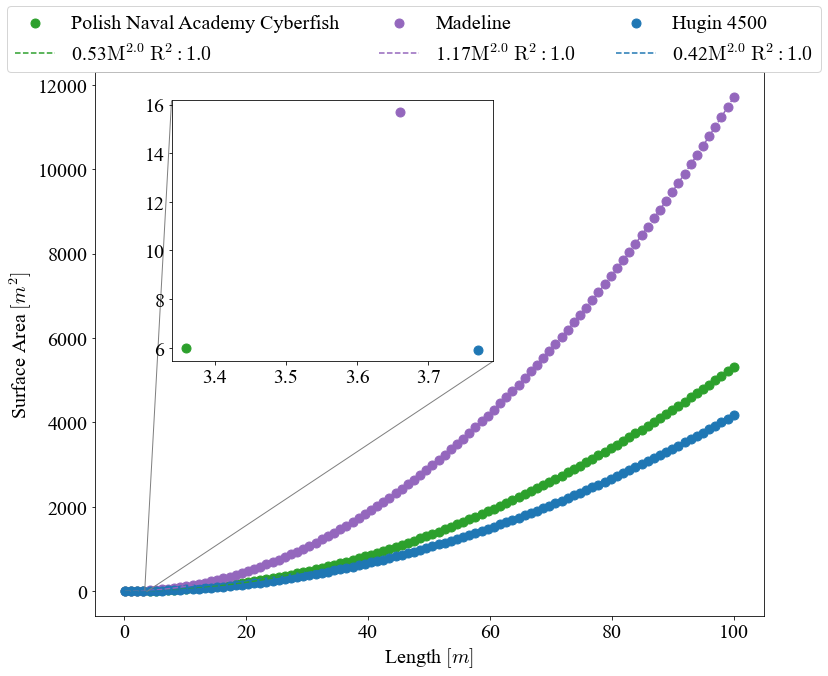

In [16]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

fig1, ax1 = plt.subplots(figsize=((12, 10)))

colors = ['tab:green', 'tab:purple', 'tab:blue']

axins = inset_axes(ax1, width="60%", height="60%",
                   bbox_to_anchor=(.1, .45, .8, .8),
                   bbox_transform=ax1.transAxes, loc=3)

model = PowerLawModel(prefix='p_')
pars = model.guess(cyberfish_area, x=scaledLength)
pars['p_amplitude'].set(value=0.1, min=0.0001, max=10)
pars['p_exponent'].set(value=2.0, min=0.1, max=5.0)

cyberfish_fit = model.fit(cyberfish_area, pars, x=scaledLength)
cyberfish_r_squared = calc_rsquared(scaledLength, cyberfish_area, cyberfish_fit.params['p_amplitude'].value, cyberfish_fit.params['p_exponent'].value)

ax1.scatter(scaledLength, cyberfish_area, color=colors[0], label = 'Polish Naval Academy Cyberfish')
ax1.plot(scaledLength, cyberfish_fit.params['p_amplitude'].value*scaledLength**cyberfish_fit.params['p_exponent'].value, '--', color=colors[0],
        label=str(np.round(cyberfish_fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(cyberfish_fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(cyberfish_r_squared, 3)) + '}$')

pars = model.guess(madeline_area, x=scaledLength)
pars['p_amplitude'].set(value=0.1, min=0.0001, max=10)
pars['p_exponent'].set(value=2.0, min=0.1, max=5.0)

madeline_fit = model.fit(madeline_area, pars, x=scaledLength)
madeline_r_squared = calc_rsquared(scaledLength, madeline_area, madeline_fit.params['p_amplitude'].value, madeline_fit.params['p_exponent'].value)


ax1.scatter(scaledLength, madeline_area, color=colors[1], label = 'Madeline')
ax1.plot(scaledLength, madeline_fit.params['p_amplitude'].value*scaledLength**madeline_fit.params['p_exponent'].value, '--', color=colors[1],
        label=str(np.round(madeline_fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(madeline_fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(madeline_r_squared, 3)) + '}$')

pars = model.guess(hugin_area, x=scaledLength)
pars['p_amplitude'].set(value=0.1, min=0.0001, max=10)
pars['p_exponent'].set(value=2.0, min=0.1, max=5.0)

hugin_fit = model.fit(hugin_area, pars, x=scaledLength)
hugin_r_squared = calc_rsquared(scaledLength, hugin_area, hugin_fit.params['p_amplitude'].value, hugin_fit.params['p_exponent'].value)


ax1.scatter(scaledLength, hugin_area, color=colors[2], label = 'Hugin 4500')
ax1.plot(scaledLength, hugin_fit.params['p_amplitude'].value*scaledLength**hugin_fit.params['p_exponent'].value, '--', color=colors[2],
        label=str(np.round(hugin_fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(hugin_fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(hugin_r_squared, 3)) + '}$')

ax1.set_ylabel('Surface Area $[m^2]$')
ax1.set_xlabel('Length $[m]$')
ax1.legend(loc=1, ncol=3, bbox_to_anchor=((1.1, 1.14)))


index_cyberfish = np.argwhere(scaledLength >= 1.69)[0]
index_madeline = np.argwhere(scaledLength >= 3.24)[0]

length_cyberfish = 3.36
length_madeline = 3.66
length_hugin = 3.77

axins.scatter(length_cyberfish, cyberfish_fit.params['p_amplitude'].value*length_cyberfish**cyberfish_fit.params['p_exponent'].value, color=colors[0])
axins.scatter(length_madeline, madeline_fit.params['p_amplitude'].value*length_madeline**madeline_fit.params['p_exponent'].value, color=colors[1])
axins.scatter(length_hugin, hugin_fit.params['p_amplitude'].value*length_hugin**hugin_fit.params['p_exponent'].value, color=colors[2])


mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")

#fig1.savefig(Path(r'./').joinpath('surface_area_designs.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [17]:
density = 1027
# deterimine the lengths in which the volumes are the same
dorado_volume = ve.ellipsoidApproximation(5.24, 0.533, 0.533)
dorado_area = sea.ellipsoidApproximation(5.24, 0.533, 0.533)
dorado_mass = density*dorado_volume

cyberfish_area, _ = sea.determine_surface_area(1, 2, 0, length_cyberfish*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
cyberfish_volume, _, _ = ve.determine_volume(1, 2, 0, length_cyberfish*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
cyberfish_mass = density*cyberfish_volume


# note that width and height dimensions are scaled with length
madeline_area, madeline_volume = square_ellipse(length_madeline, length_madeline*0.167, length_madeline*0.564)
madeline_mass = density*madeline_volume

hugin_area = sea.ellipsoidApproximation(length_hugin, length_hugin*0.167, length_hugin*0.167)
hugin_volume = ve.ellipsoidApproximation(length_hugin, length_hugin*0.167, length_hugin*0.167)
hugin_mass = density*hugin_volume

conv_params = np.array([7.26, 3.16])
bcf_params = np.array([11.275, 2.89])
mpf_params = np.array([25.556, 2.08])
lift_params = np.array([40.606, 0.78])

dorado_weight = 680.39
dorado_weight_relation = dorado_weight - conv_params[0]*5.24**conv_params[1]
cyberfish_weight = conv_params[0]*length_cyberfish**conv_params[1]
madeline_weight = conv_params[0]*length_madeline**conv_params[1]
hugin_weight = conv_params[0]*length_hugin**conv_params[1]

dorado_excess = dorado_mass-dorado_weight
cyberfish_excess = cyberfish_mass - cyberfish_weight
madeline_excess = madeline_mass - madeline_weight
hugin_excess = hugin_mass - hugin_weight

print('Dorado: ' + '(' + str(5.24) + ',' + str(dorado_volume) + ',' + str(dorado_area) + ',' + str(dorado_weight) + ',' + str(dorado_excess) + ') \n'
      '(' + str(length_cyberfish) + ',' + str(cyberfish_volume) + ',' + str(cyberfish_area) + ',' + str(cyberfish_weight) + ',' + str(cyberfish_excess) + ') \n', 
      '(' + str(length_madeline) + ',' + str(madeline_volume) + ',' + str(madeline_area) + ',' + str(madeline_weight) + ',' + str(madeline_excess) +  ') \n', 
      '(' + str(length_hugin) + ',' + str(hugin_volume) + ',' + str(hugin_area) + ',' + str(hugin_weight) + ',' + str(hugin_excess) +  ')')



Dorado: (5.24,0.7794429394193525,6.924079223222123,680.39,120.09789878367508) 
(3.36,0.7844277346482422,6.002682064210962,334.32491068147783,471.2823728022669) 
 (3.66,3.6268426373833087,15.678783354259659,438.06327992809366,3286.704108664564) 
 (3.77,0.7824482349851576,5.928084370095561,481.0334611324236,322.54087619733326)


In [18]:
dorado_foam = dorado_excess / np.abs(300-density)
cyberfish_foam = cyberfish_excess / np.abs(300-density)
madeline_foam = madeline_excess / np.abs(300-density)
hugin_foam = hugin_excess / np.abs(300-density)

print(dorado_foam, cyberfish_foam, madeline_foam, hugin_foam)

0.16519655953737974 0.6482563587376435 4.520913491973266 0.44366007730032087


In [19]:
database_path = r'./'
database_file = r'UUVDatabase.xlsx'
data_path = Path(database_path, database_file)
bcfDF = pd.read_excel(data_path, sheet_name = 'BCF')
mpfDF = pd.read_excel(data_path, sheet_name='MPF')
convDF = pd.read_excel(data_path, sheet_name = 'Propeller')
liftDF = pd.read_excel(data_path, sheet_name="LiftBased")

In [26]:
conv_len = convDF[convDF['Length [m]'].notnull()]
bcf_len = bcfDF[bcfDF['Length [m]'].notnull()]
mpf_len = mpfDF[mpfDF['Length [m]'].notnull()]
lift_len = liftDF[liftDF['Length [m]'].notnull()]

# sort the column values in ascending order
conv_len = conv_len.sort_values('Weight [kg]')
bcf_len = bcf_len.sort_values('Weight [kg]')
mpf_len = mpf_len.sort_values('Weight [kg]')
lift_len = lift_len.sort_values('Weight [kg]')

# drop all rows with nan values
conv_len.dropna(subset=['Weight [kg]'], inplace=True)
bcf_len.dropna(subset=['Weight [kg]'], inplace=True)
mpf_len.dropna(subset=['Weight [kg]'], inplace=True)
lift_len.dropna(subset=['Weight [kg]'], inplace=True)

In [28]:
density = 1027

_, A_s, _ = sea.equivalentSpheroid(df['Length [m]'].values, df['Weight [kg]'].values, density)
df.insert(len(df.columns), 'SA', value=A_s)
df.dropna(subset=['SA'], inplace=True)

_, A_s, _ = sea.equivalentSpheroid(df['Length [m]'].values, df['Weight [kg]'].values, density)
df.insert(len(df.columns), 'SA', value=A_s)
df.dropna(subset=['SA'], inplace=True)

_, A_s, _ = sea.equivalentSpheroid(df['Length [m]'].values, df['Weight [kg]'].values, density)
df.insert(len(df.columns), 'SA', value=A_s)
df.dropna(subset=['SA'], inplace=True)

_, A_s, _ = sea.equivalentSpheroid(df['Length [m]'].values, df['Weight [kg]'].values, density)
df.insert(len(df.columns), 'SA', value=A_s)
df.dropna(subset=['SA'], inplace=True)

/home/mco143/Documents/gitRepos/Cost-of-Transport-Estimation/Scripts/surfaceAreaEstimators.py:260: RuntimeWarning: invalid value encountered in sqrt
  ellipsicity = np.sqrt(1-np.divide(np.square(D_s), np.square(length)))
/tmp/ipykernel_229349/1491567061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['SA'], inplace=True)
/tmp/ipykernel_229349/1491567061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['SA'], inplace=True)
/home/mco143/Documents/gitRepos/Cost-of-Transport-Estimation/Scripts/surfaceAreaEstimators.py:260: RuntimeWarning: invalid value encountered in sqrt
  ellips

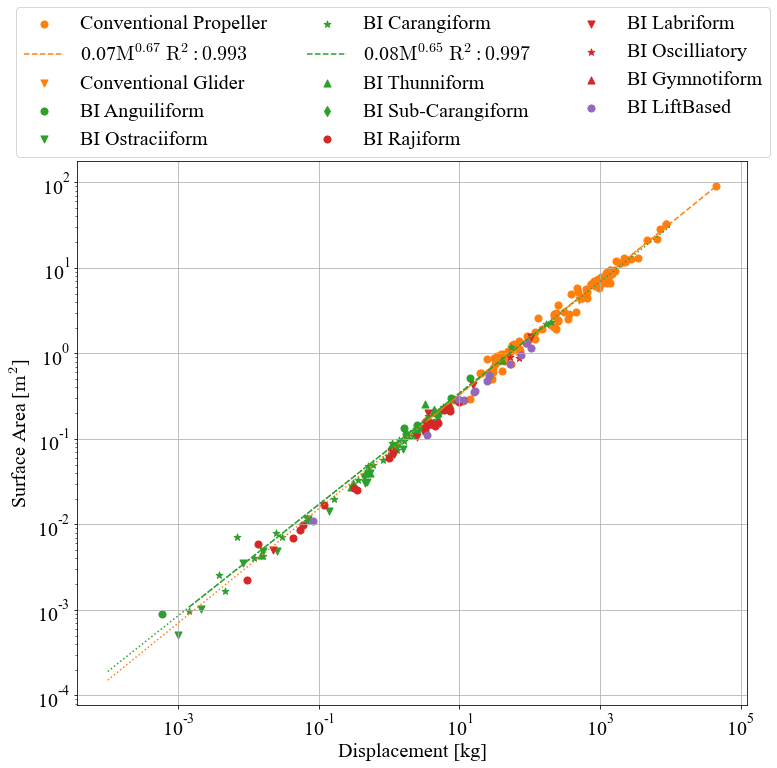

In [37]:
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']

model = PowerLawModel(prefix='p_')
dx = np.linspace(1e-4, 1e4, 50)       

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        data = conv_dfs[i].sort_values(by=['Weight [kg]'])
        if mode == 'Propeller':
                pars = model.guess(data['SA'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=2.0)
                
                fit = model.fit(data['SA'].values, pars, x=data['Weight [kg]'].values)

                r_squared = calc_rsquared(data['Weight [kg]'].values, data['SA'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax2.scatter(data['Weight [kg]'], data['SA'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col + '--', 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax2.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax2.scatter(data['Weight [kg]'], data['SA'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

for i, mode in enumerate(bcf_modes):
        col = 'C2'
        # perform fits for data
        data = bcf_dfs[i].sort_values(by=['Weight [kg]'])
        if mode == 'Carangiform':
                pars = model.guess(data['SA'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=2.0)

                fit = model.fit(data['SA'], pars, x=data['Weight [kg]'])

                r_squared = calc_rsquared(data['Weight [kg]'].values, data['SA'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

                ax2.scatter(data['Weight [kg]'], data['SA'], marker=markers[i], color='C2', s=marker_size, label='BI ' + mode)
                ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col + '--', 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax2.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax2.scatter(data['Weight [kg]'], data['SA'], marker=markers[i], color='C2', s=marker_size, label='BI ' + mode)

for i, mode in enumerate(mpf_modes):
        col = 'C2'
        # perform fits for data
        data = mpf_dfs[i].sort_values(by=['Weight [kg]'])

        # pars = model.guess(data['SA'].values, x=data['Weight [kg]'].values)
        # pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
        # pars['p_exponent'].set(value=0.5, min=0.001, max=2.0)

        # fit = model.fit(data['SA'], pars, x=data['Weight [kg]'])

        # r_squared = calc_rsquared(data['Weight [kg]'].values, data['SA'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

        ax2.scatter(data['Weight [kg]'], data['SA'], marker=markers[i], color='tab:red', s=marker_size, label='BI ' + mode)
        # ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col + '--', 
        #         label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
        #         + str(np.round(r_squared, 3)) + '}$')
        # ax2.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')

for i, mode in enumerate(lift_modes):
        col = 'C2'
        # perform fits for data
        data = lift_dfs[i].sort_values(by=['Weight [kg]'])

        # pars = model.guess(data['SA'].values, x=data['Weight [kg]'].values)
        # pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
        # pars['p_exponent'].set(value=0.5, min=0.001, max=2.0)

        # fit = model.fit(data['SA'], pars, x=data['Weight [kg]'])

        # r_squared = calc_rsquared(data['Weight [kg]'].values, data['SA'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

        ax2.scatter(data['Weight [kg]'], data['SA'], marker=markers[i], color='tab:purple', s=marker_size, label='BI ' + mode)
        # ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col + '--', 
        #         label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
        #         + str(np.round(r_squared, 3)) + '}$')
        # ax2.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')

ax2.set_xlabel('Displacement [kg]')
ax2.set_ylabel('Surface Area [$\mathrm{m^2}$]')
ax2.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 0.99))
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.grid()
fig2.savefig('surface_area_displacement.pdf', facecolor='w', dpi=300, bbox_inches='tight')